<a href="https://colab.research.google.com/github/nmoisseeva/mv_ozone/blob/main/task3_nox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
#February 8, 2024

#This script looks for trends in NOx by station

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import os
import requests
import string
import pickle


mpl.rcParams['figure.dpi'] = 200



### INPUT ###

nox_path = '/content/drive/MyDrive/colab/consulting/mv/NOx.xlsx'
# ap2024_path = '/content/drive/MyDrive/colab/consulting/mv/PM_2013-2023.xlsx'
meta_path = '/content/drive/MyDrive/colab/consulting/mv/SelectMeta.xlsx'
fig_path = '/content/drive/MyDrive/colab/consulting/mv/figs/task3'
ozone_1h_path = '/content/drive/MyDrive/colab/consulting/mv/ozone_1h.pkl'
ozone_8h_path = '/content/drive/MyDrive/colab/consulting/mv/ozone_8h.pkl'
# temp_1h_path = '/content/drive/MyDrive/colab/consulting/mv/temperature_1h.pkl'
# heat_events_path = '/content/drive/MyDrive/colab/consulting/mv/heat_events.pkl'
pm_24h_path = '/content/drive/MyDrive/colab/consulting/mv/pm_24h.pkl'


stations = ['T004', 'T006', 'T009', 'T012', 'T013', 'T014', 'T015',
       'T017', 'T018', 'T020', 'T026', 'T027', 'T029', 'T030', 'T031', 'T032','T033']
pm_stations = ['T004','T009','T012','T020','T027','T029','T031'] #smoke stations



quantiles = [0.5,0.98, 1]
lmt = [[0,30], [0,300], [0,300]]  #plot limits for 1h plots


### end of input ###




In [128]:
nox.keys()

Index(['T001', 'T002', 'T004', 'T006', 'T009', 'T012', 'T013', 'T014', 'T015',
       'T017', 'T018', 'T020', 'T026', 'T027', 'T029', 'T030', 'T031', 'T032',
       'T033', 'T034', 'T035', 'T039', 'T043', 'T044', 'T045', 'T046', 'T050'],
      dtype='object')

In [5]:
#import data
nox = pd.read_excel(nox_path,\
                      header=2, index_col=0, parse_dates=False, skiprows = lambda x: x in [3, 4], \
                       na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232','AutoCal','Purge','Spare','OutCal','Vandalism','Change','FailPwr','CntReachSt'])


In [6]:
#default date parsing flips month and day - do manually
nox.index = pd.to_datetime(nox.index,format='%d/%m/%Y %H:%M')

#convert data to float
nox.convert_dtypes()


,T001,T002,T004,T006,T009,T012,T013,T014,T015,T017,...,T032,T033,T034,T035,T039,T043,T044,T045,T046,T050
Date & Time,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,82.0,87.0,42.0,22.0,44.0,10.0,42.0,<NA>,5.0,94.0,...,58.0,20.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2002-01-01 01:00:00,66.0,87.0,31.0,22.0,40.0,7.0,35.0,<NA>,5.0,78.0,...,57.0,20.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2002-01-01 02:00:00,68.0,87.0,49.0,35.0,41.0,6.0,32.0,<NA>,5.0,66.0,...,69.0,22.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2002-01-01 03:00:00,<NA>,81.0,<NA>,25.0,<NA>,4.0,23.0,<NA>,4.0,76.0,...,72.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2002-01-01 04:00:00,78.0,78.0,24.0,25.0,44.0,4.0,12.0,<NA>,4.0,63.0,...,25.0,5.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,28.5,<NA>,7.1,<NA>,21.7,45.2,27.5,5.2,18.8,35.5,...,11.2,14.4,<NA>,14.2,10.7,20.2,27.2,10.7,23.6,68.6
2023-12-31 20:00:00,27.3,<NA>,6.4,<NA>,16.0,29.3,30.3,3.3,16.6,42.9,...,19.5,18.9,<NA>,12.6,6.4,12.7,20.7,17.2,29.7,71.9
2023-12-31 21:00:00,30.5,<NA>,3.3,<NA>,24.2,23.6,33.0,3.8,11.5,50.0,...,17.8,15.3,<NA>,15.1,11.3,19.1,16.7,18.8,33.5,57.4


In [7]:
#import metadata
meta = pd.read_excel(meta_path)
meta['MV_ID'] = meta.MV_ID.apply(lambda x: 'T' + x[1:].zfill(3))
meta.set_index(meta.MV_ID, inplace=True)
meta.index.rename('stations', inplace=True)
meta.convert_dtypes()

,NAPS_ID,MV_ID,StationName,Address,Municipality,Notes,Active,Lat,Lon,Elev
stations,,,,,,,,,,
T001,100112,T001,DOWNTOWN VANCOUVER,ROBSON SQUARE - ROBSON AND HORNBY STREET Room ...,VANCOUVER,<NA>,1,49.282272,123.12188,32.0
T002,100118,T002,VANCOUVER-KITSILANO,2550 WEST 10TH AVENUE,VANCOUVER,Started Nov 18 1986. Non-operational since May...,1,49.261672,123.163472,34.0
T004,100110,T004,BURNABY-KENSINGTON PARK,6400 E. HASTINGS STREET,BURNABY,<NA>,1,49.279214,122.970707,104.0
T006,100121,T006,NORTH VANCOUVER-SECOND NARROWS,75 RIVERSIDE DRIVE,NORTH VANCOUVER,<NA>,1,49.301472,123.020417,4.0
T009,100111,T009,PORT MOODY,MOODY STREET AND ESPLANADE,PORT MOODY,<NA>,1,49.280893,122.849291,6.0
T012,101101,T012,CHILLIWACK,CHILLIWACK AIRPORT 46360 Airport Road.,CHILLIWACK,Moved to Airport May 1994,1,49.155848,121.940279,12.0
T013,100125,T013,NORTH DELTA,8544 - 116TH STREET,DELTA,<NA>,1,49.158348,122.90173,113.0
T014,100126,T014,BURNABY MOUNTAIN,SIMON FRASER UNIVERSITY - West Mall Building,BURNABY,"Moved to West Mall Building Sept 21, 2004",1,49.279809,122.922267,360.0
T015,100127,T015,SURREY EAST,"Clayton Reservoir - 19000 BLOCK, 72ND AVENUE",SURREY,"In this location started Jan 31, 2022 (choose ...",1,49.133219,122.695491,79.0


In [8]:
grp_1h = nox.groupby(nox.index.year)
nox_24h = nox.rolling(24, min_periods=18,step=24, closed='right').mean()

#shift to label average to beginning of the day (deafult is right edge of averaging window which is midnight next day)
nox_24h.index = nox_24h.index.shift(-1,'D')
grp_24h = nox_24h.groupby(nox_24h.index.year)

In [ ]:
#-----optional: check for random missing data strings-------
# pd.to_numeric(pm_1h.T035)
# stations = ['T004','T009','T012','T020','T027','T029','T031','T035'] #for pm



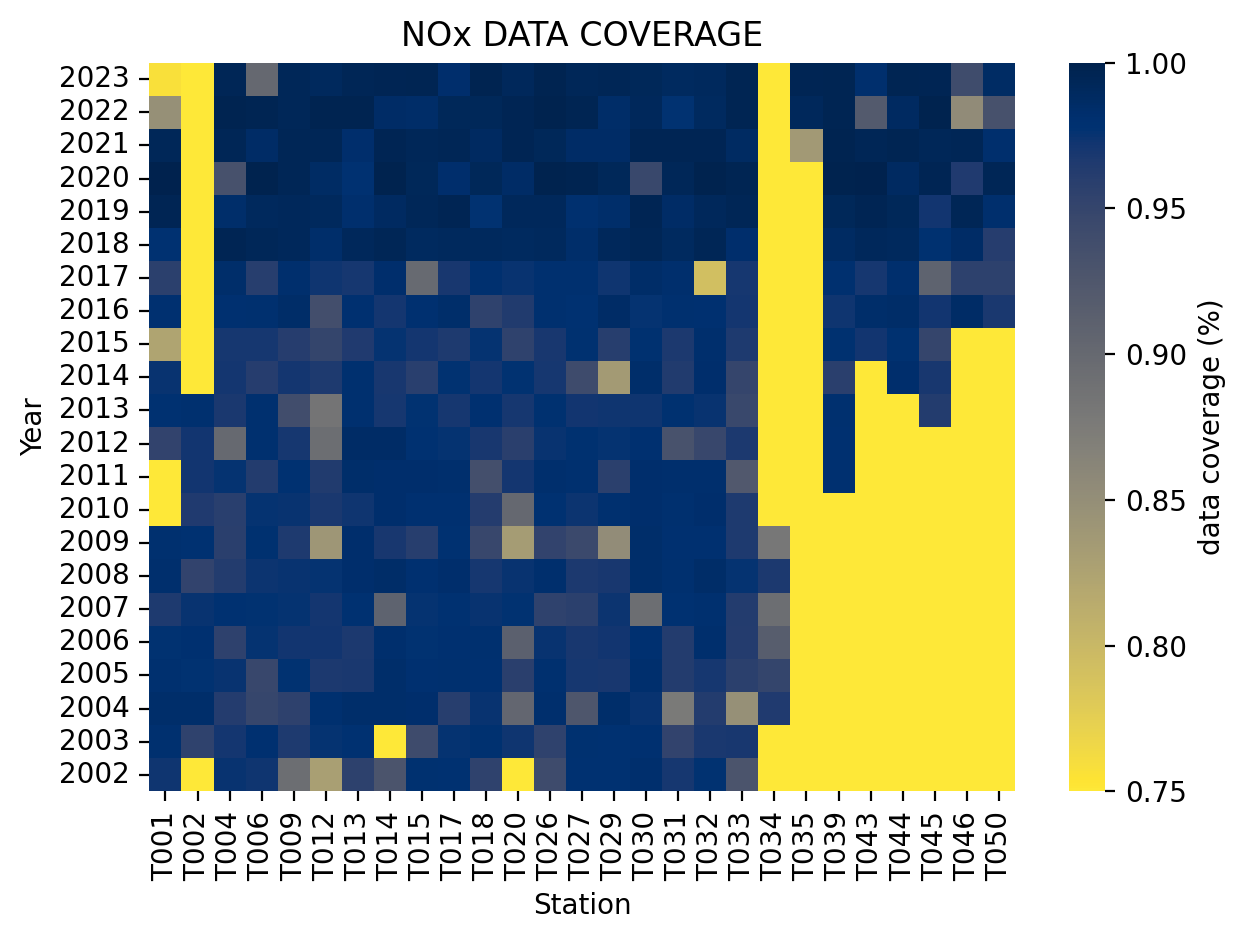

In [130]:
#look at how complete the data is
data_frac = grp_1h.count()/8760

plt.figure()
ax = plt.gca()
sns.heatmap(data_frac, vmin=0.75, vmax=1,cmap='cividis_r',cbar_kws={'label': 'data coverage (%)'})
ax.set(ylabel='Year', xlabel='Station', title='NOx DATA COVERAGE')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(fig_path,'data_coverage_nox.pdf'))


In [ ]:
# #sanity check: outlier check
# ozone_1h.boxplot()

In [131]:
# set up storage dataframe for trends
qKeys = ['stations'] + [f'Q{i}' for i in quantiles] + ['lat'] + ['lon']
trends = pd.DataFrame(columns = qKeys)
trends['stations'] = stations
trends.set_index(trends.stations, inplace=True)


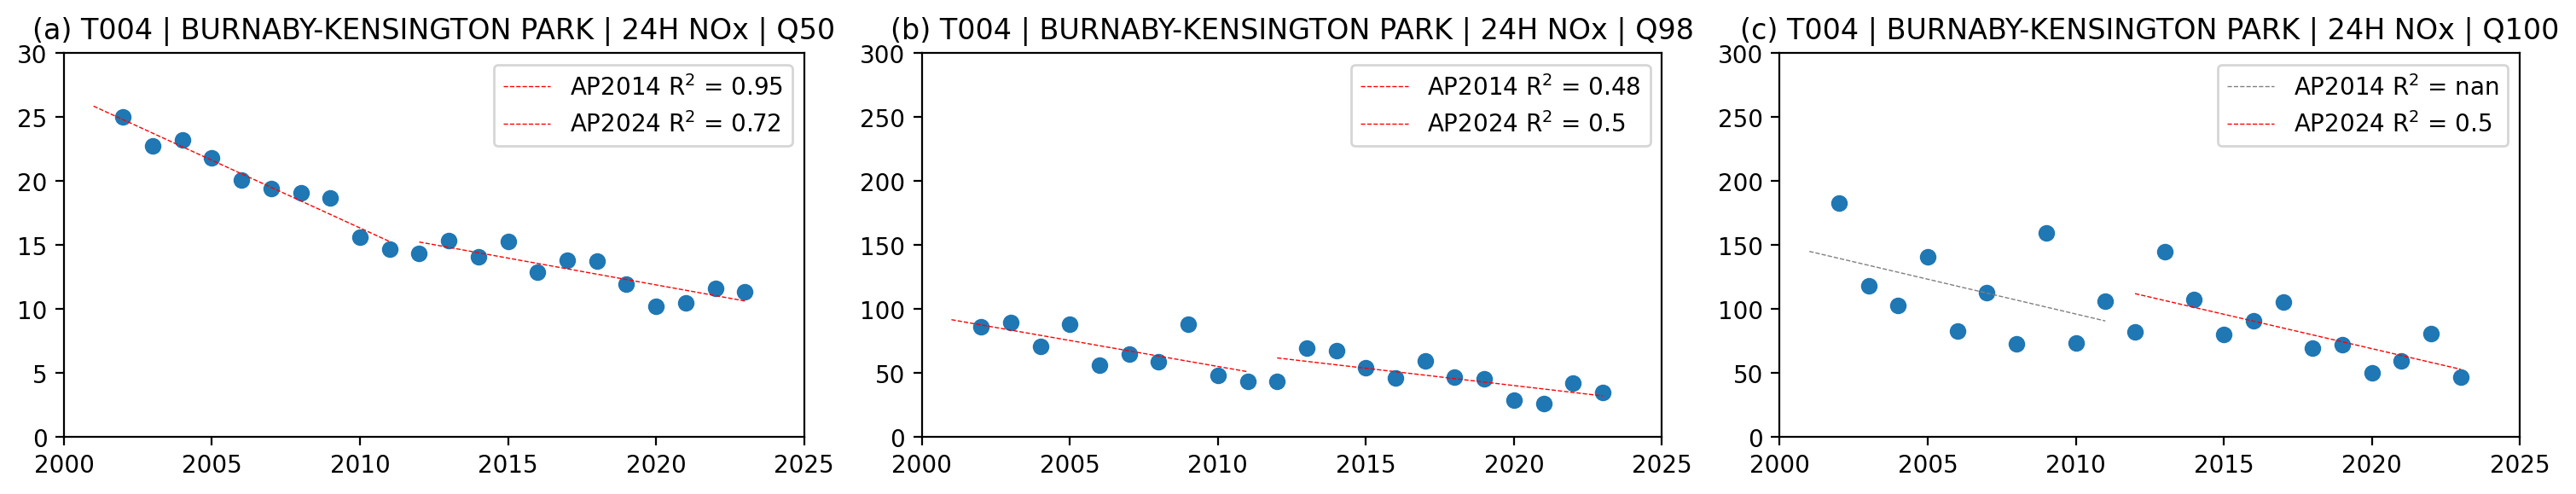

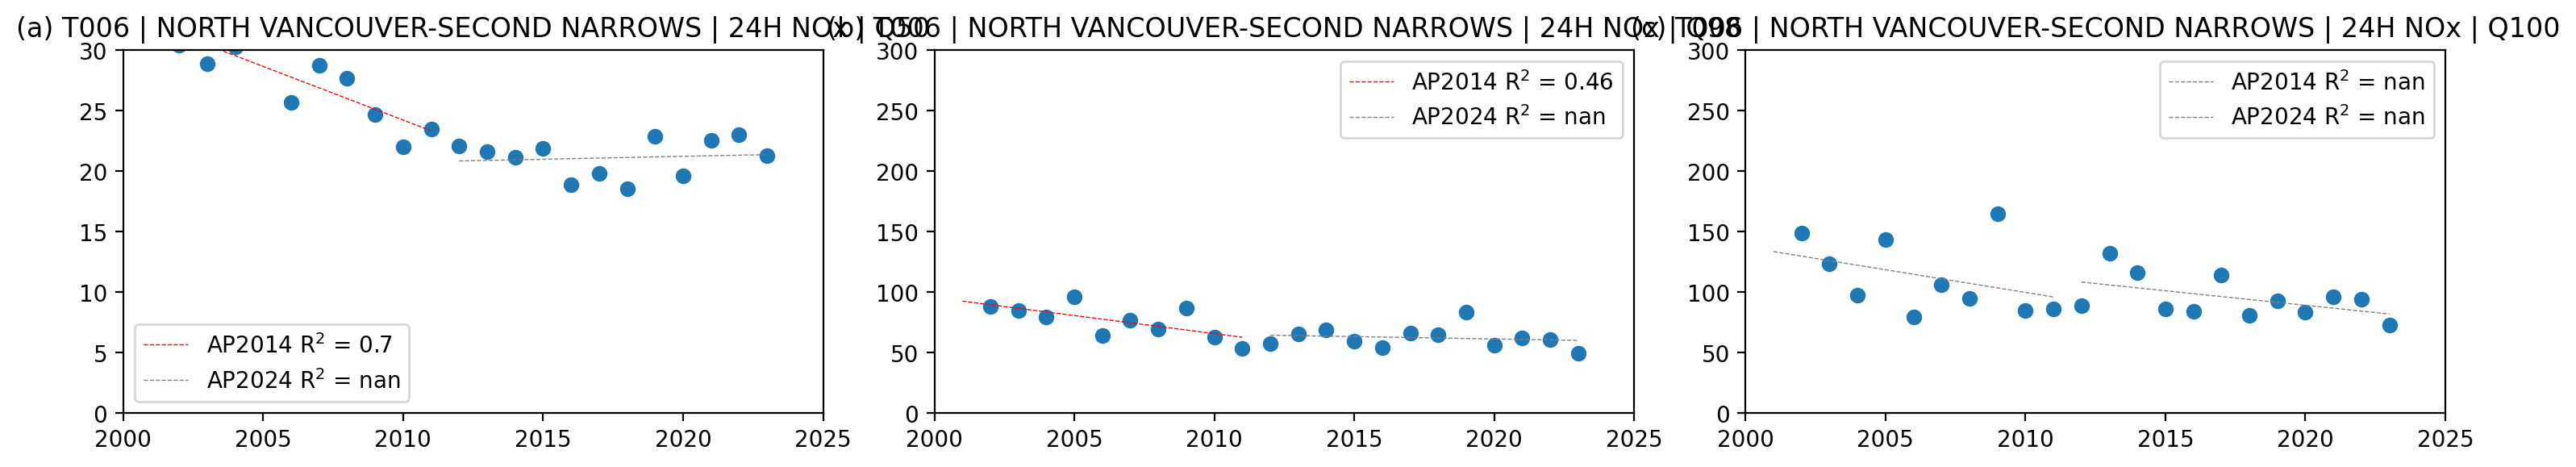

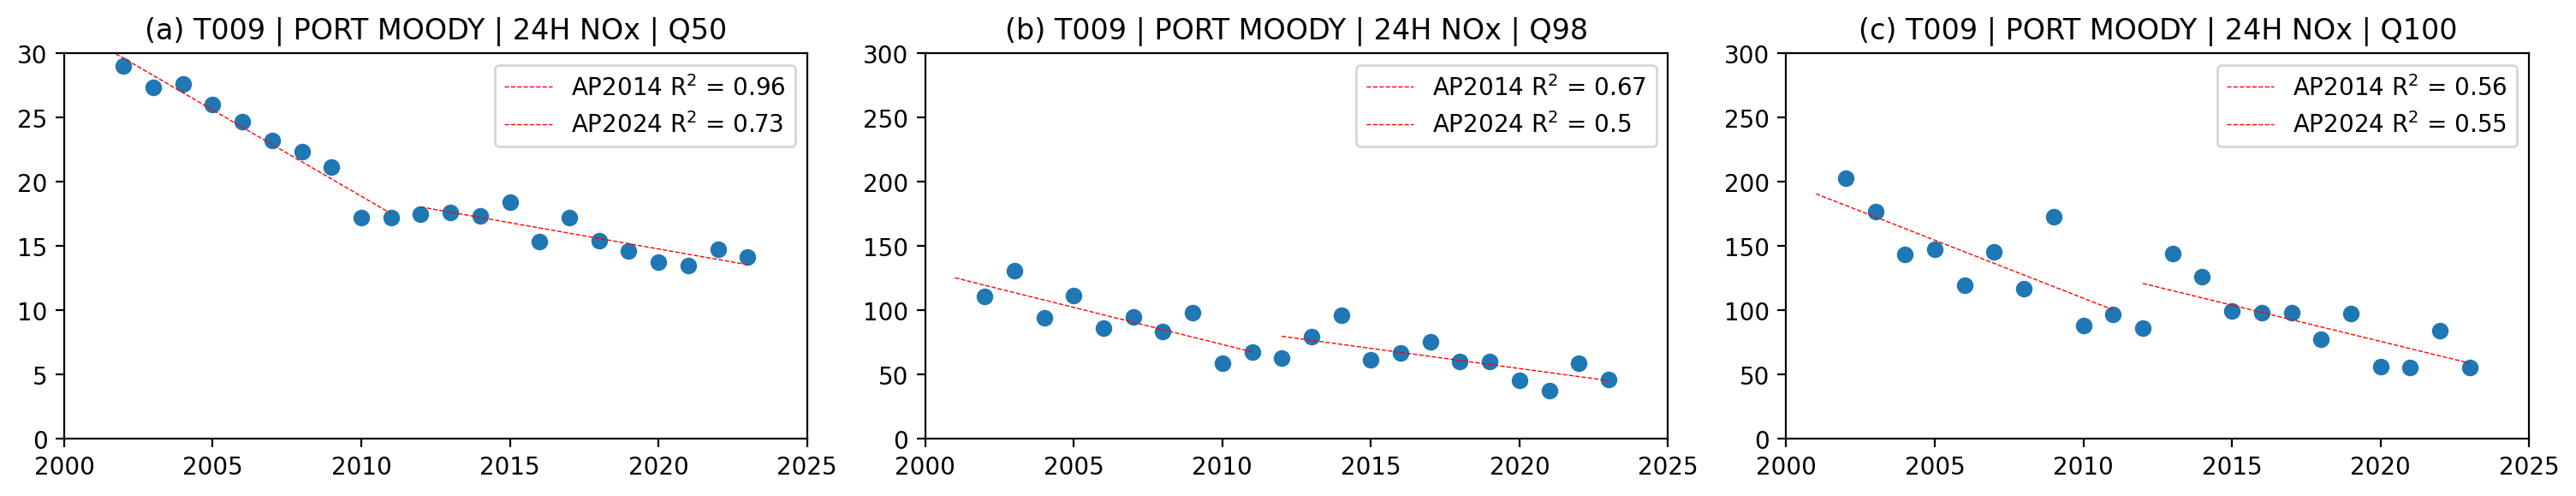

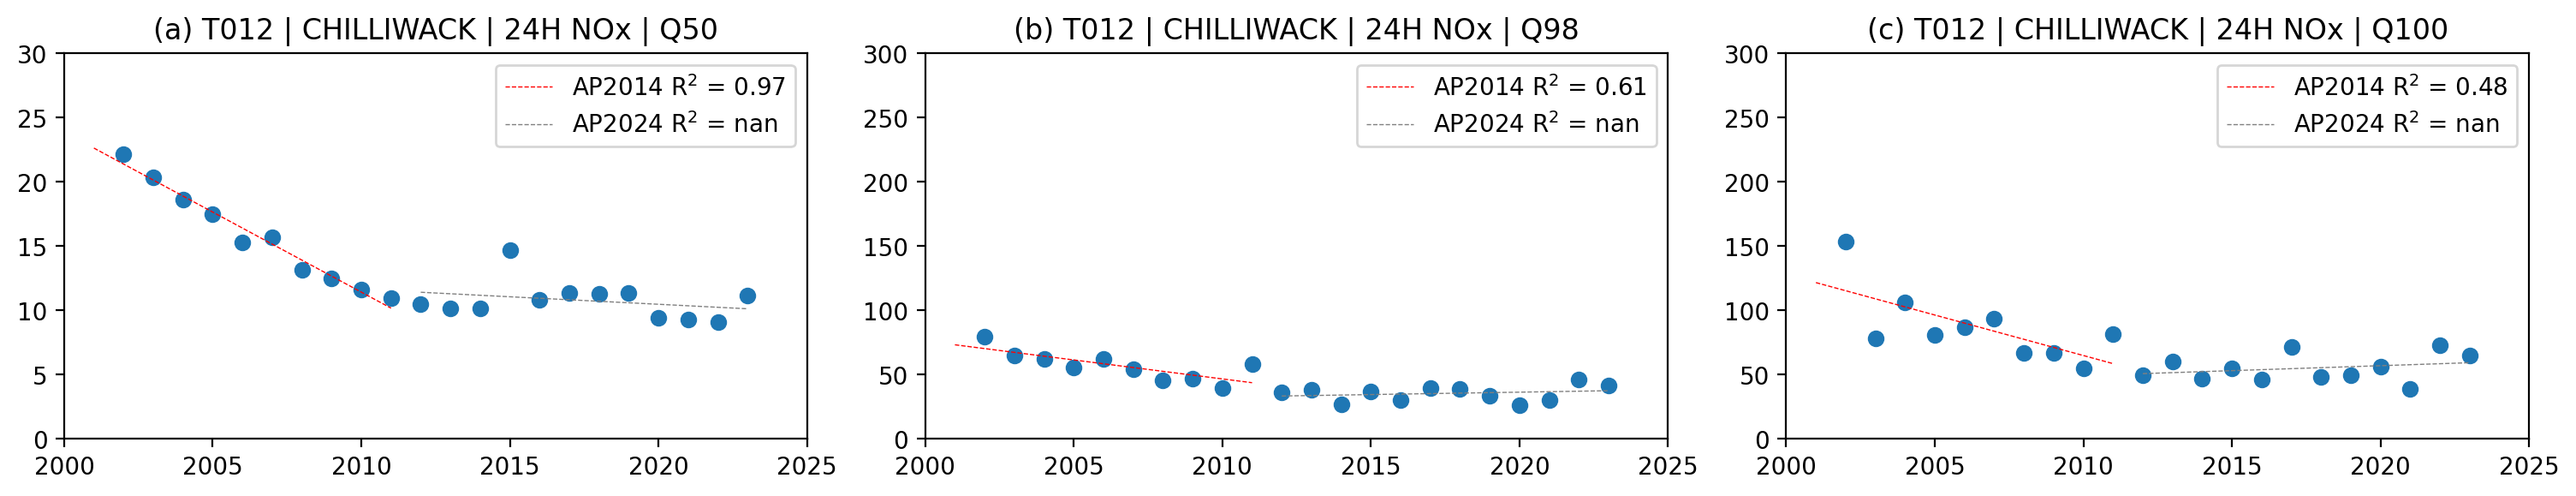

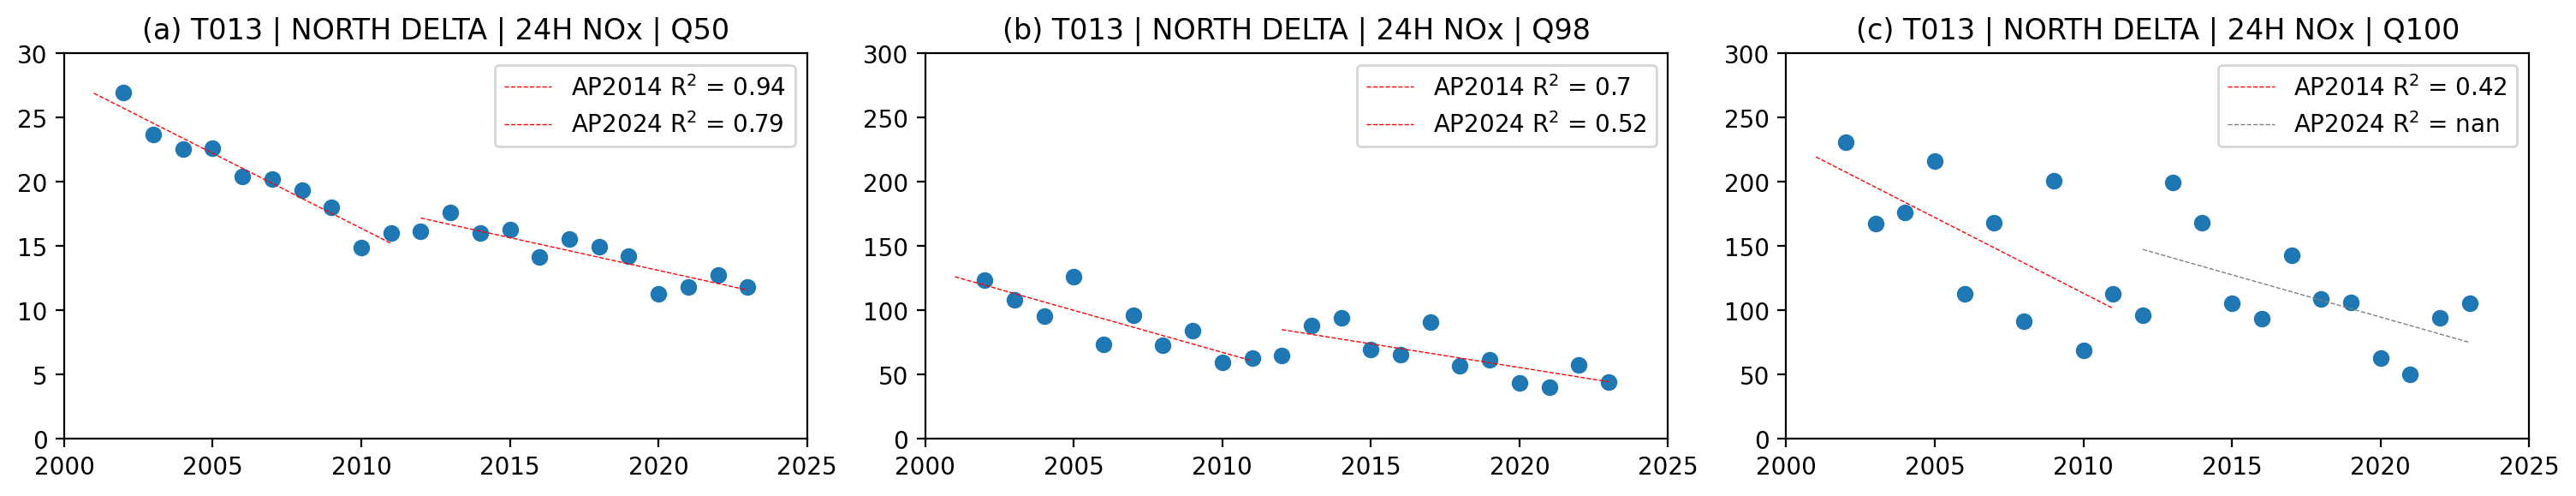

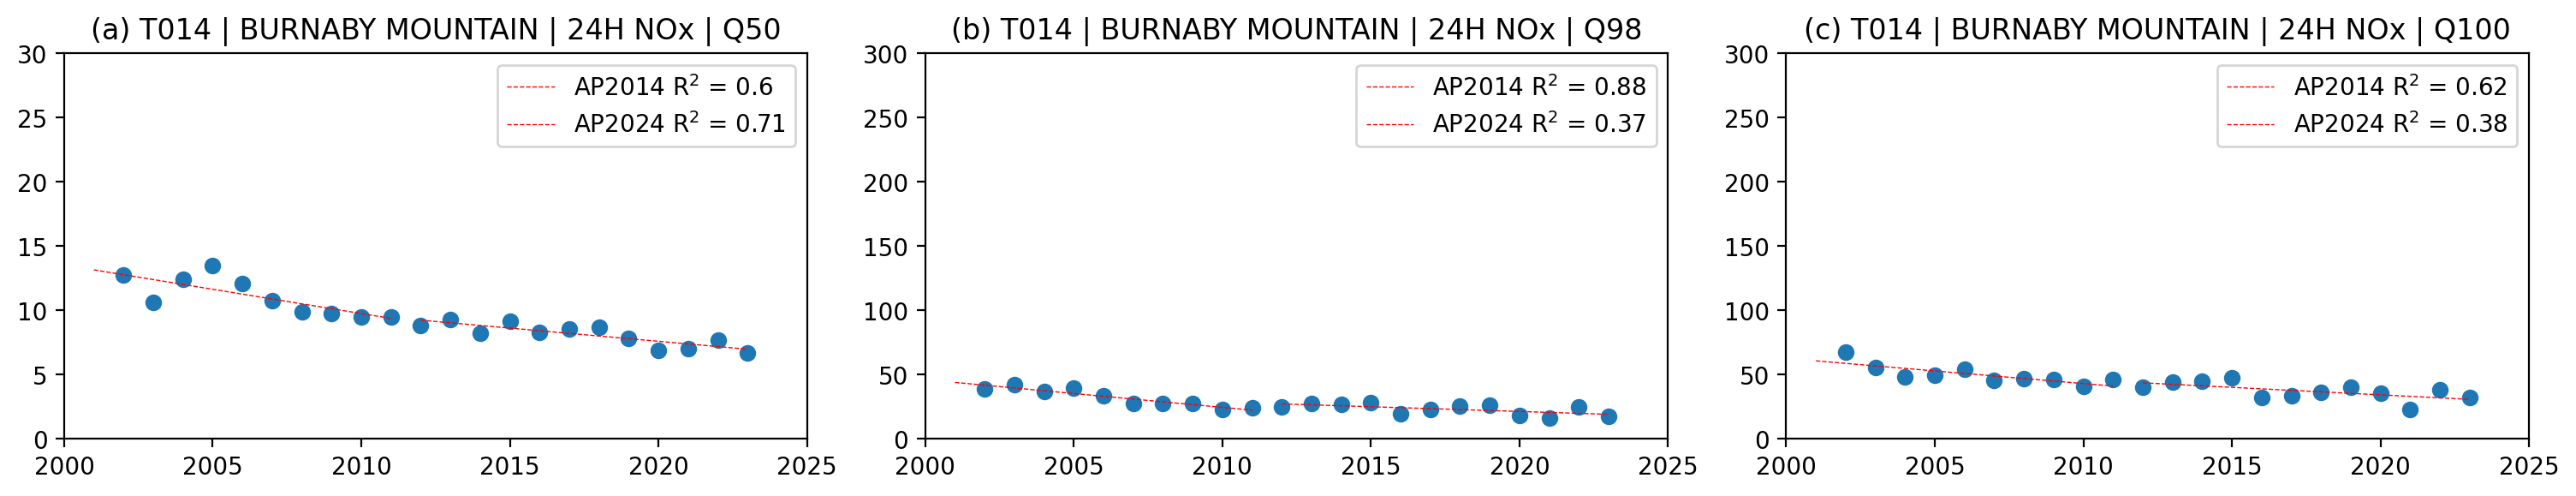

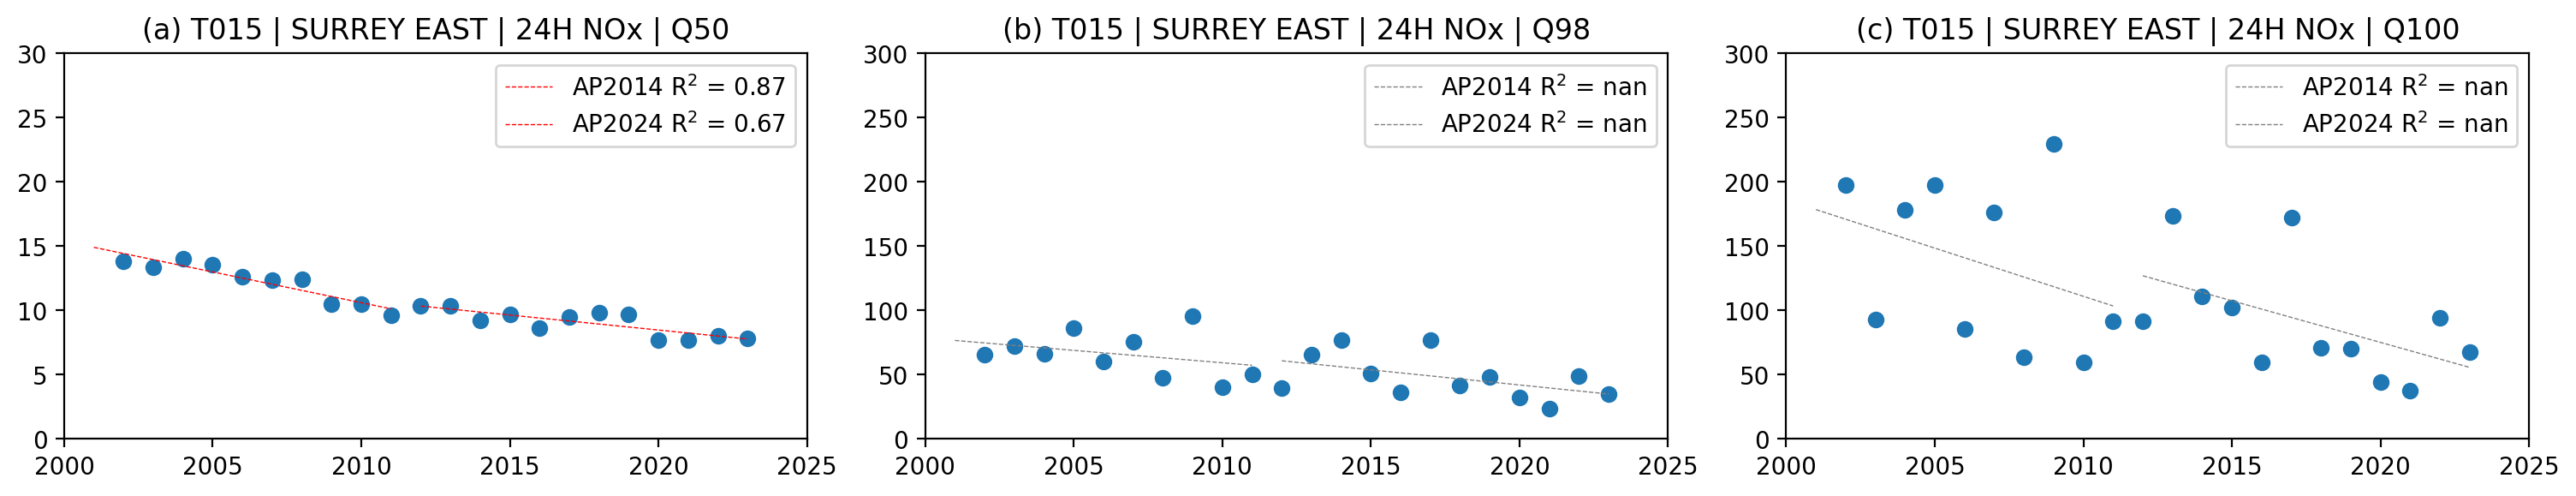

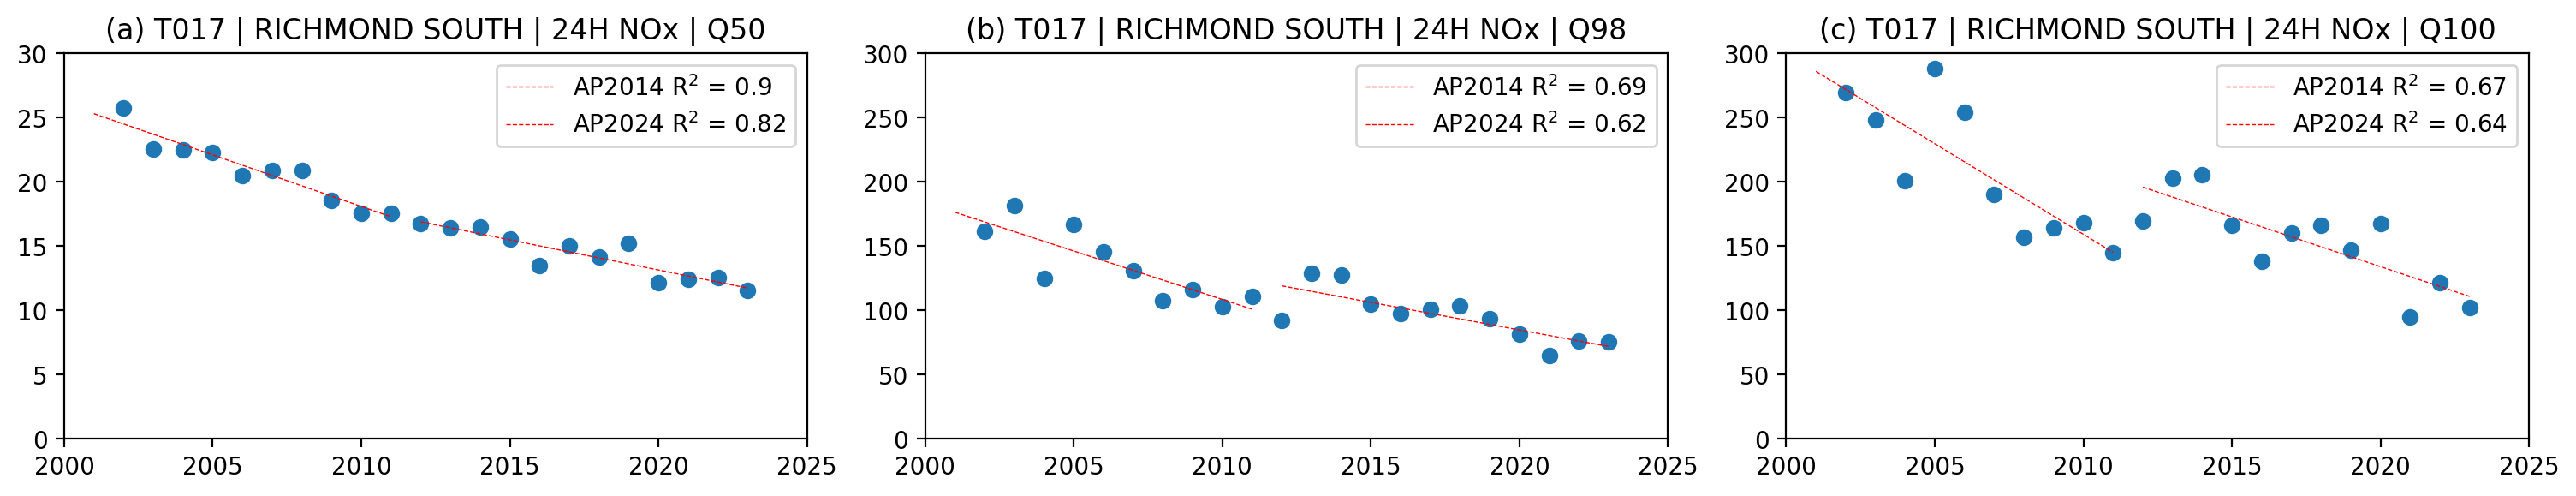

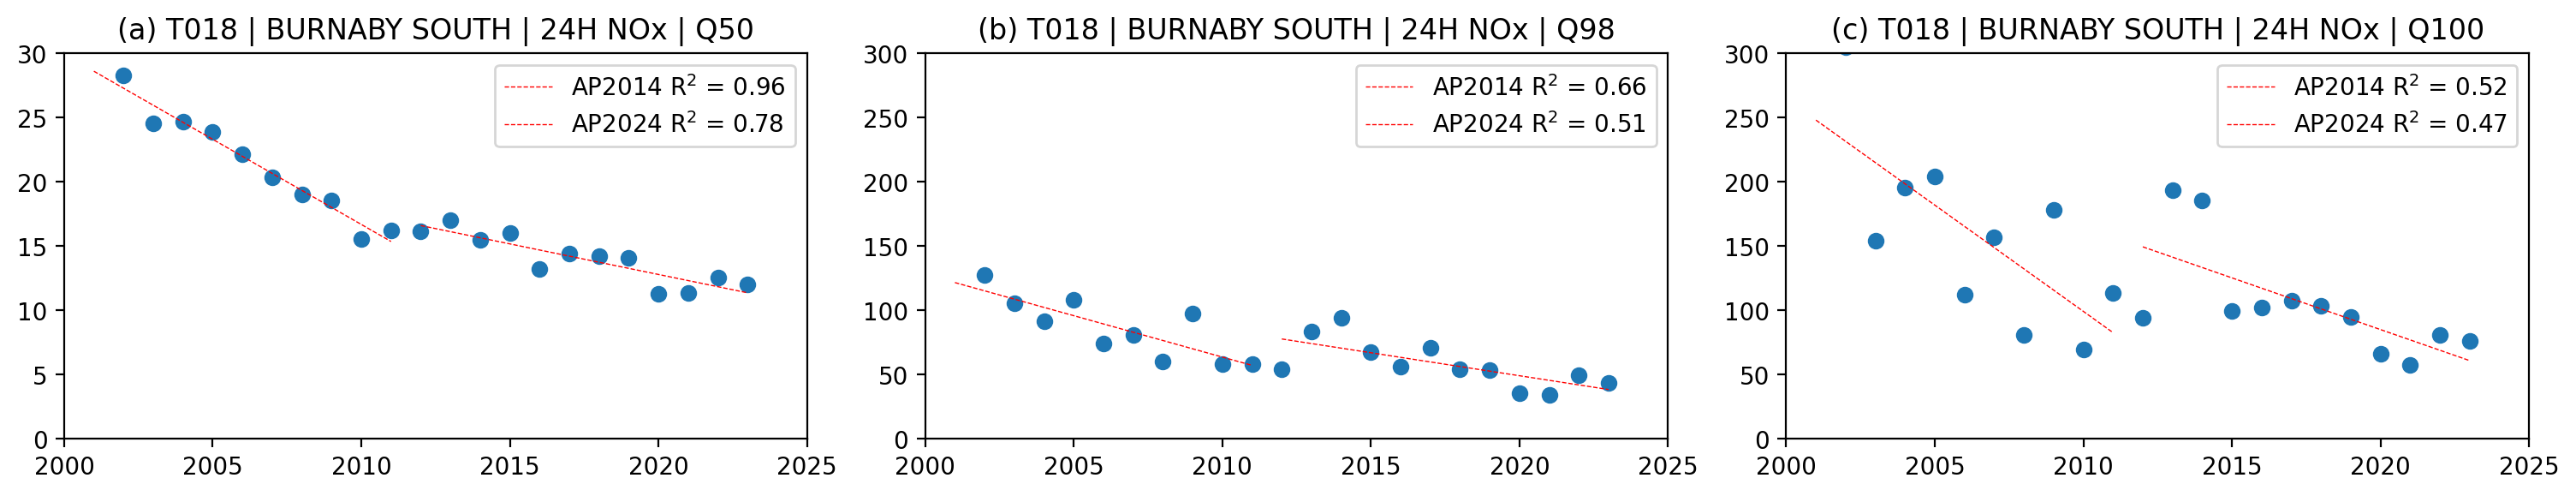

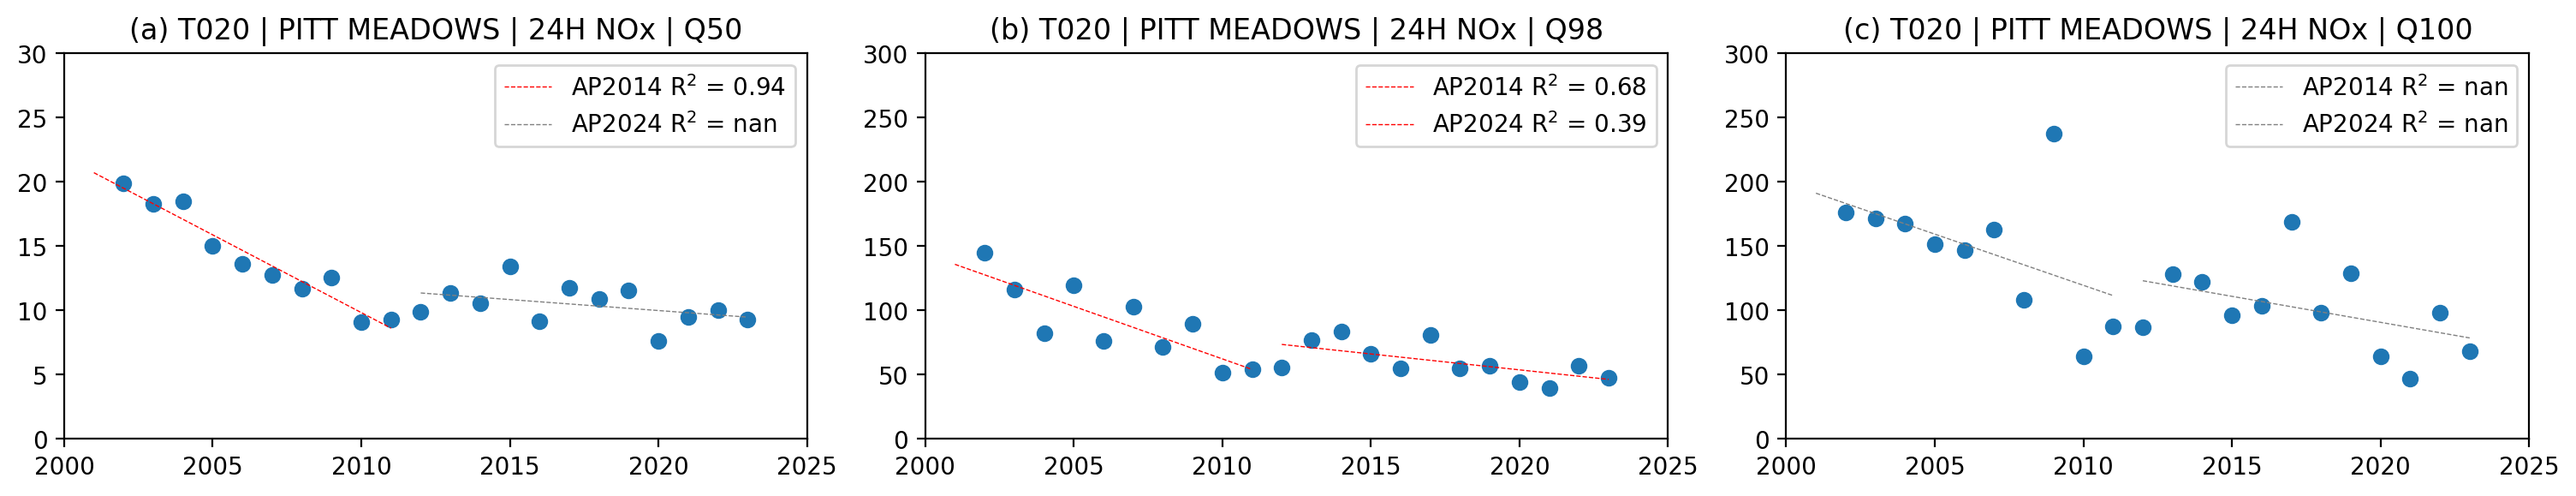

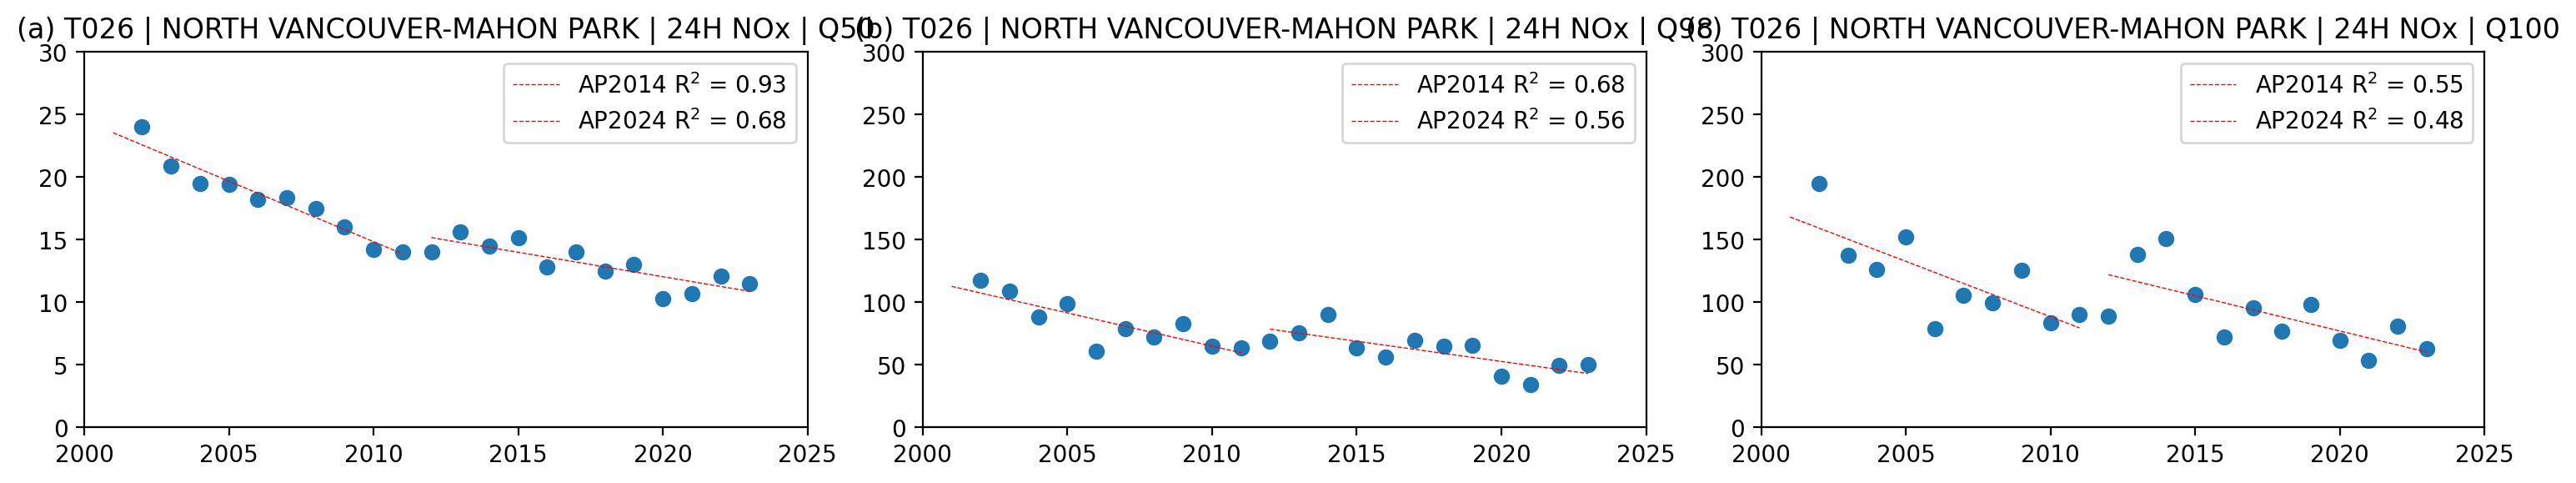

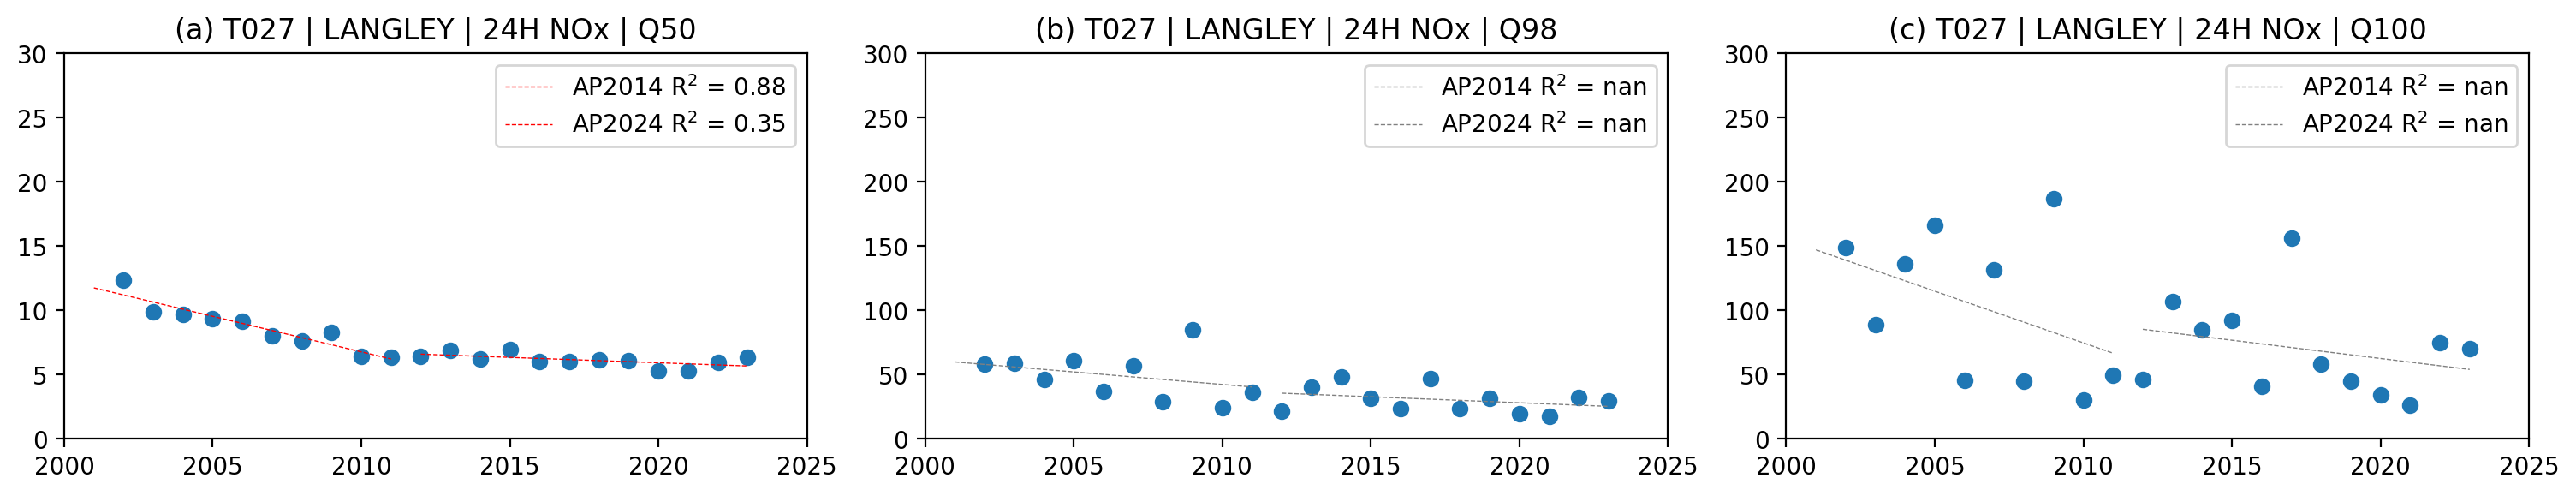

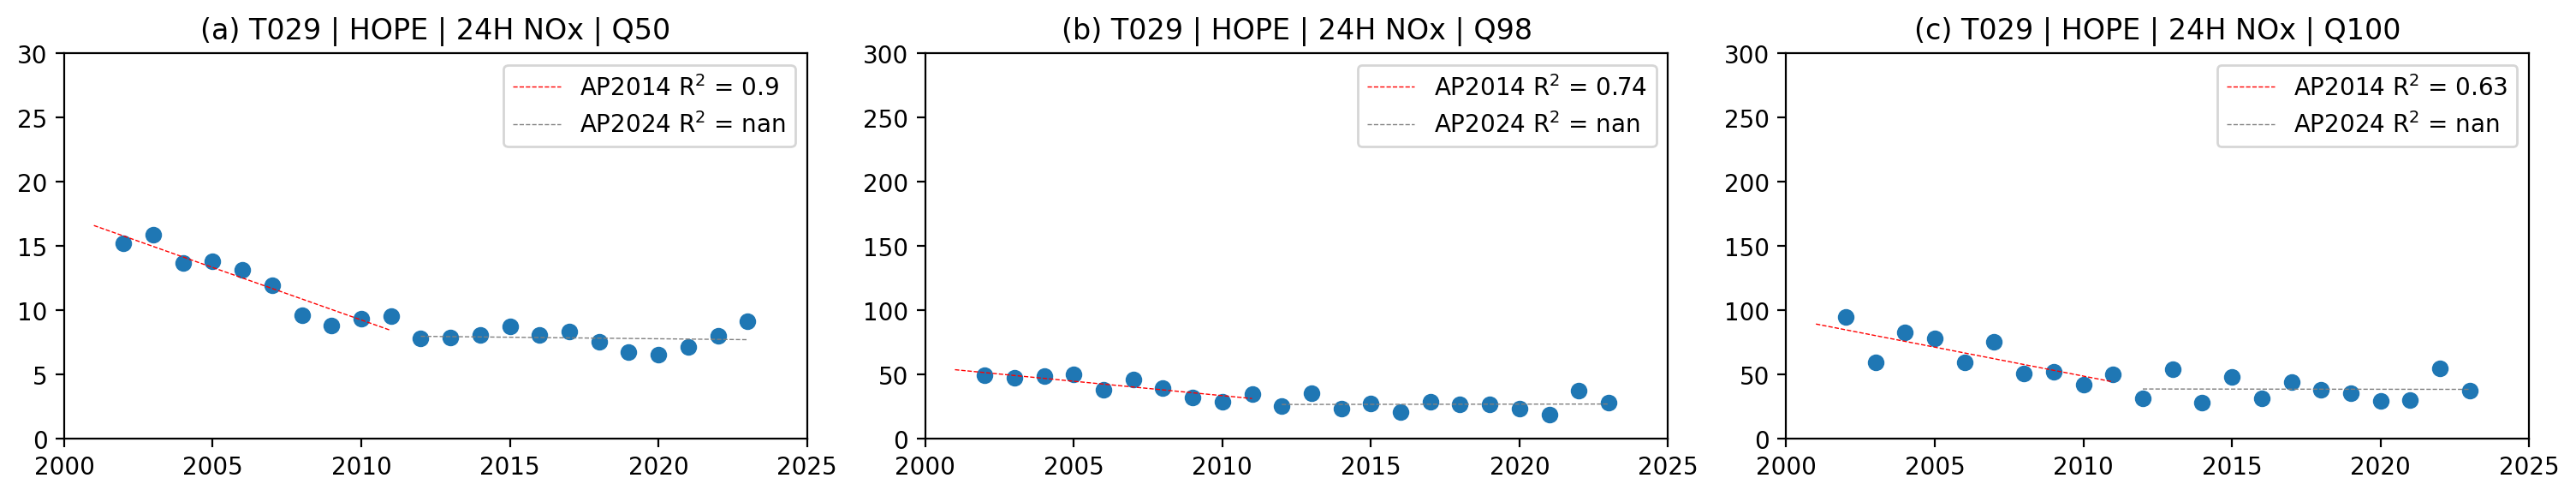

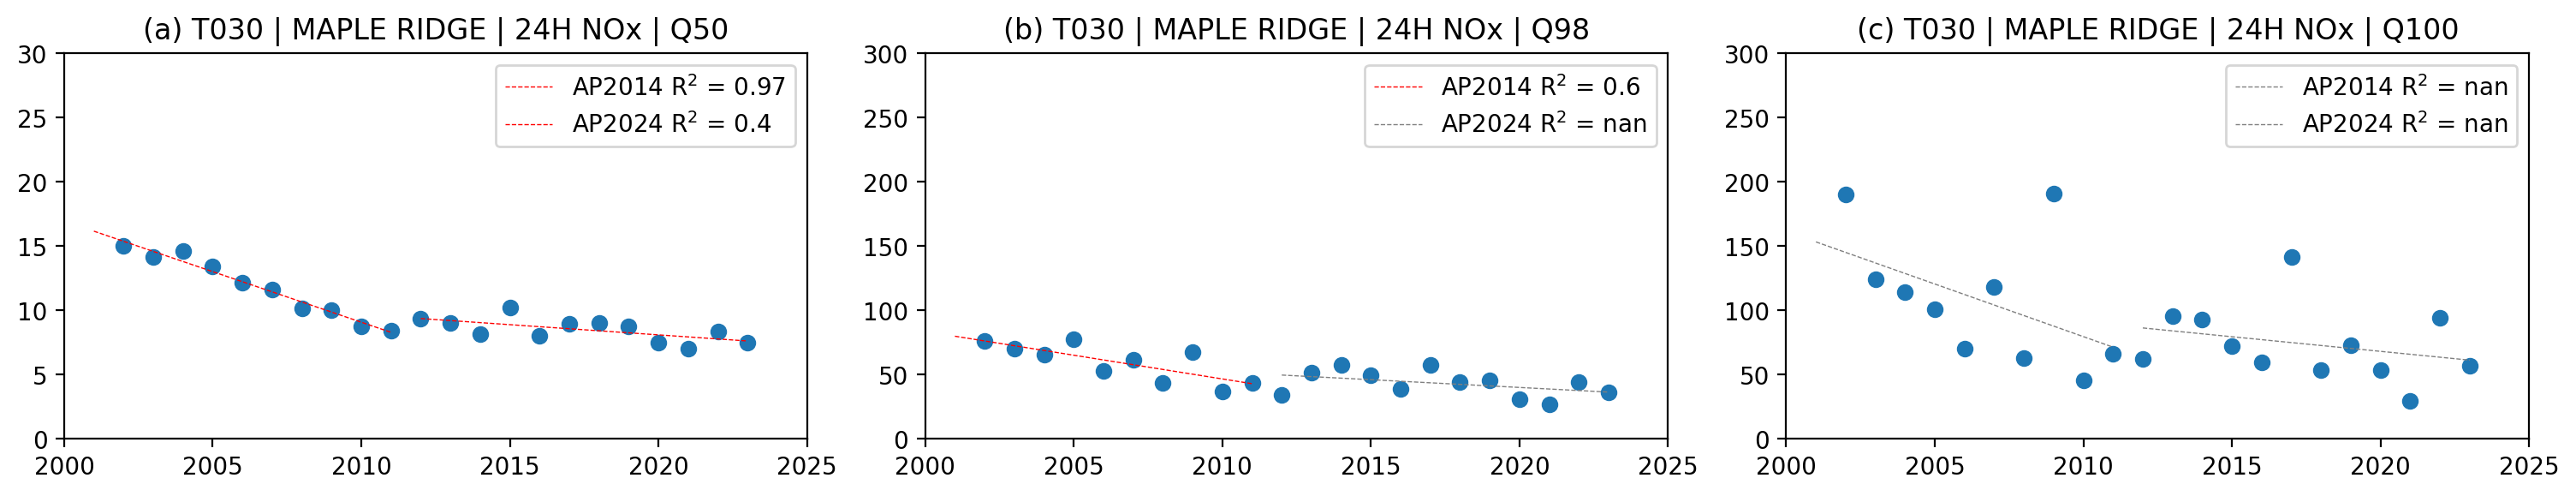

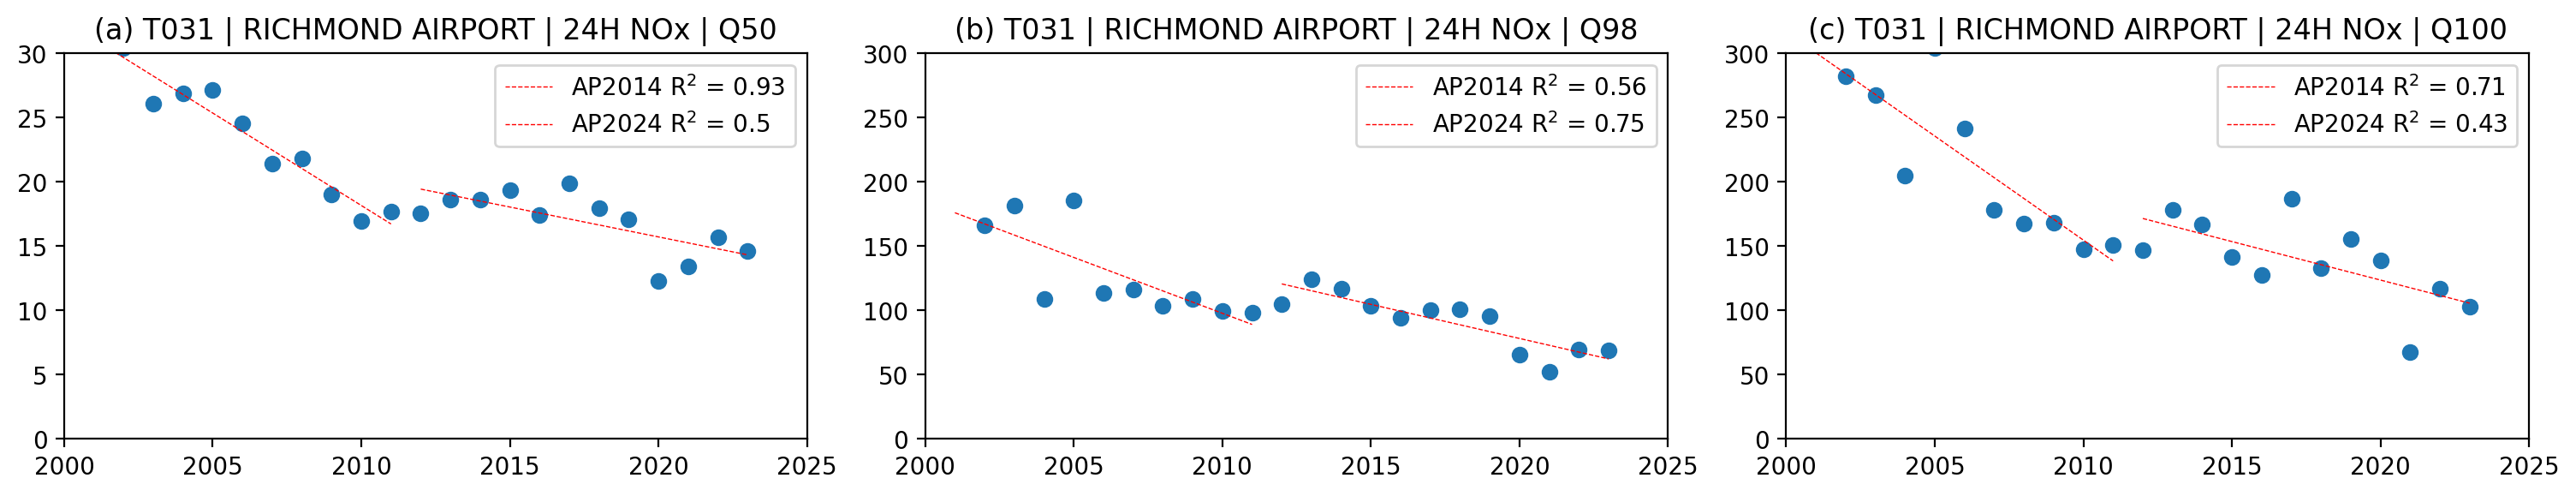

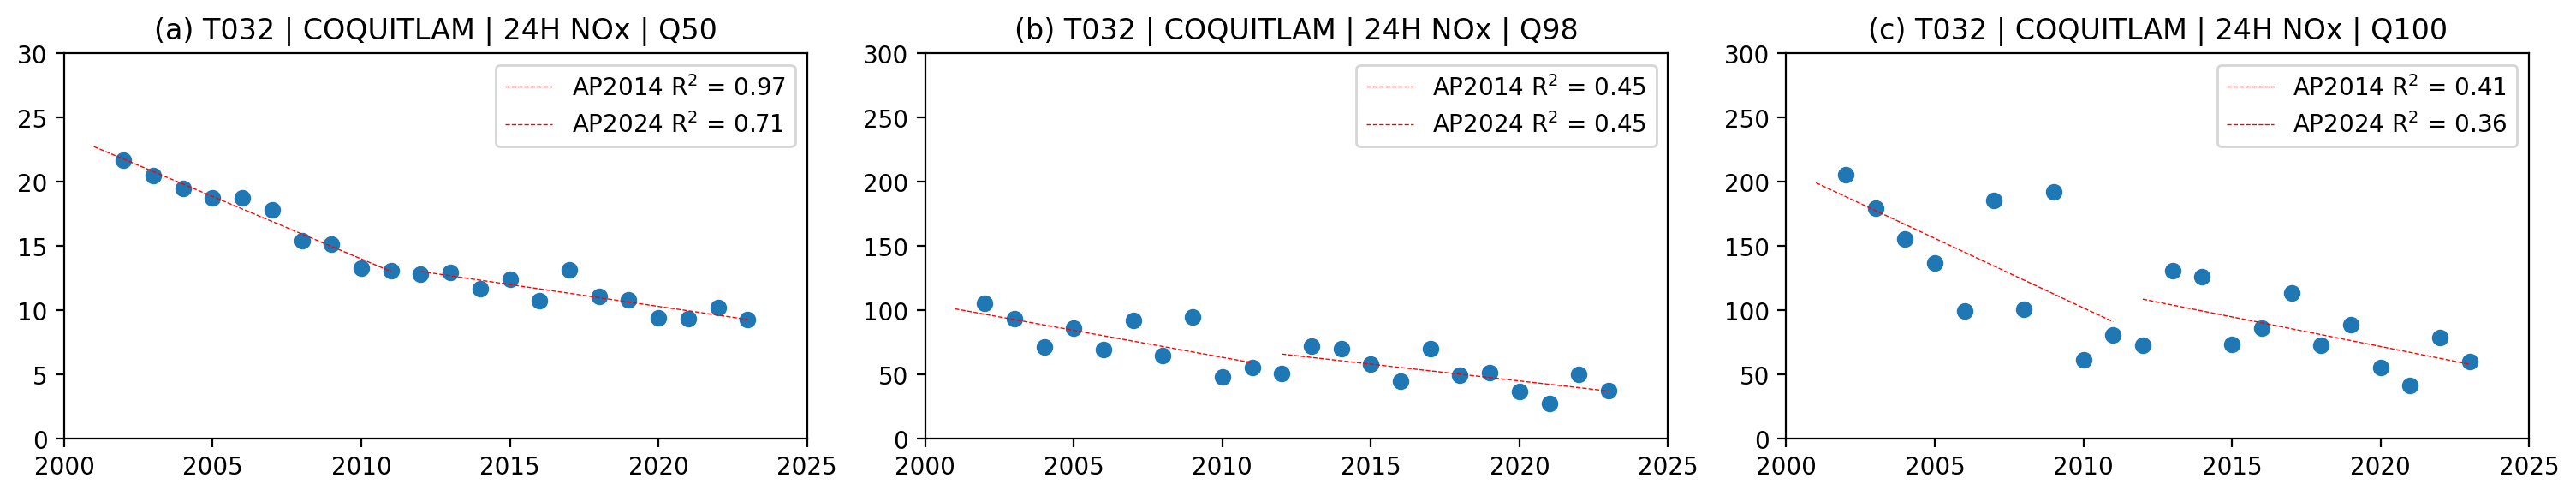

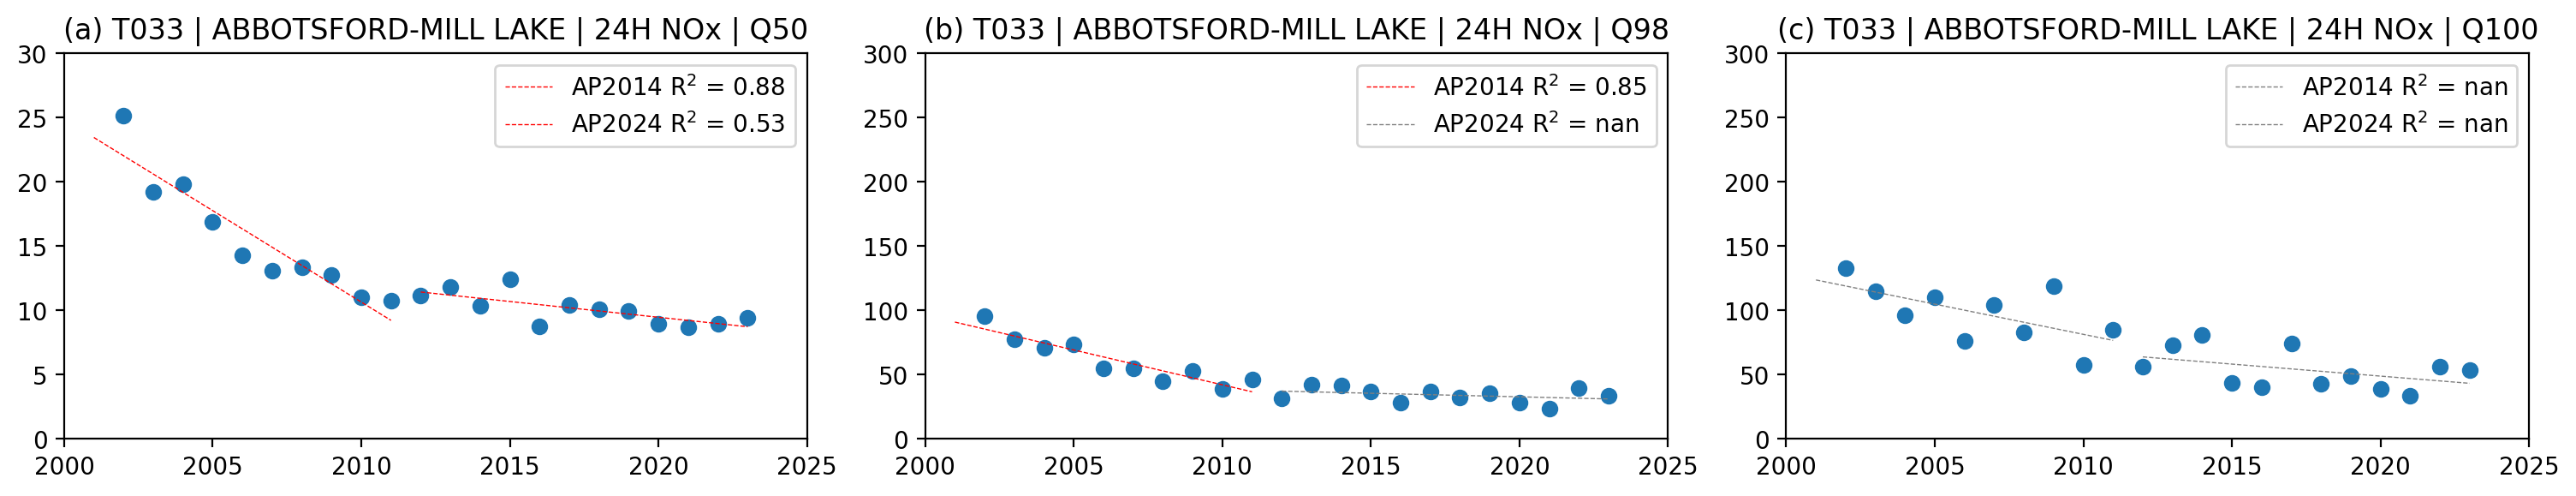

In [138]:
 #-------------24H NOx------------------
plt_tag = [f'({i})' for i in list(string.ascii_lowercase)]

#loop through stations
for nStn, stn in enumerate(stations):

  #loop through quantiles
  numQnt = len(quantiles) + 1
  plt.figure(figsize=(5*numQnt,3))
  for nQ, qnt in enumerate(quantiles):

    #gather data
    q = grp_24h[stn].quantile(q=qnt)

    #------trendline------
    #add constant to predictor variables
    x = sm.add_constant(q.index.values)

    try:
      model2014 = sm.OLS(q[:11], x[:11], missing='drop').fit()
      trend2014 = model2014.predict(exog=x[:11])
    except:
      trend2014 = np.ones(np.shape(q[:11])) * np.nan
      print(f'No data to perform OLS: {stn} for AP2014 Q{int(qnt*100)}')
    try:
      model2024 = sm.OLS(q[11:], x[11:], missing='drop').fit()
      trend2024 = model2024.predict(exog=x[11:])
    except:
      trend2024 = np.ones(np.shape(q[11:])) * np.nan
      print(f'No data to perform OLS: {stn} for AP2024 Q{int(qnt*100)}')

   #----plotting-----
    plt.subplot(1,numQnt,nQ + 1)
    ax = plt.gca()
    plt.scatter(y = q, x=q.index)
    plt.plot(x[:11,1],trend2014,c=['red' if model2014.pvalues.x1<0.05 else 'gray'][0],\
            linestyle='--', linewidth = 0.5, \
            label = f'AP2014 R$^2$ = {[round(model2014.rsquared,2) if model2014.pvalues.x1<0.05 else "nan"][0]}')
    plt.plot(x[11:,1],trend2024,c=['red' if model2024.pvalues.x1<0.05 else 'gray'][0],\
            linestyle='--', linewidth = 0.5, \
            label = f'AP2024 R$^2$ = {[round(model2024.rsquared,2) if model2024.pvalues.x1<0.05 else "nan"][0]}')
    ax.set(title = f'{plt_tag[nQ]} {stn} | {meta.loc[stn,"StationName"]} | 24H NOx | Q{int(qnt*100)}', xlim=[2000, 2025], ylim=lmt[nQ])
    plt.legend()
    plt.tight_layout()
  plt.savefig(os.path.join(fig_path,'trends', f'{stn}_nox_24H.pdf'),bbox_inches = 'tight')




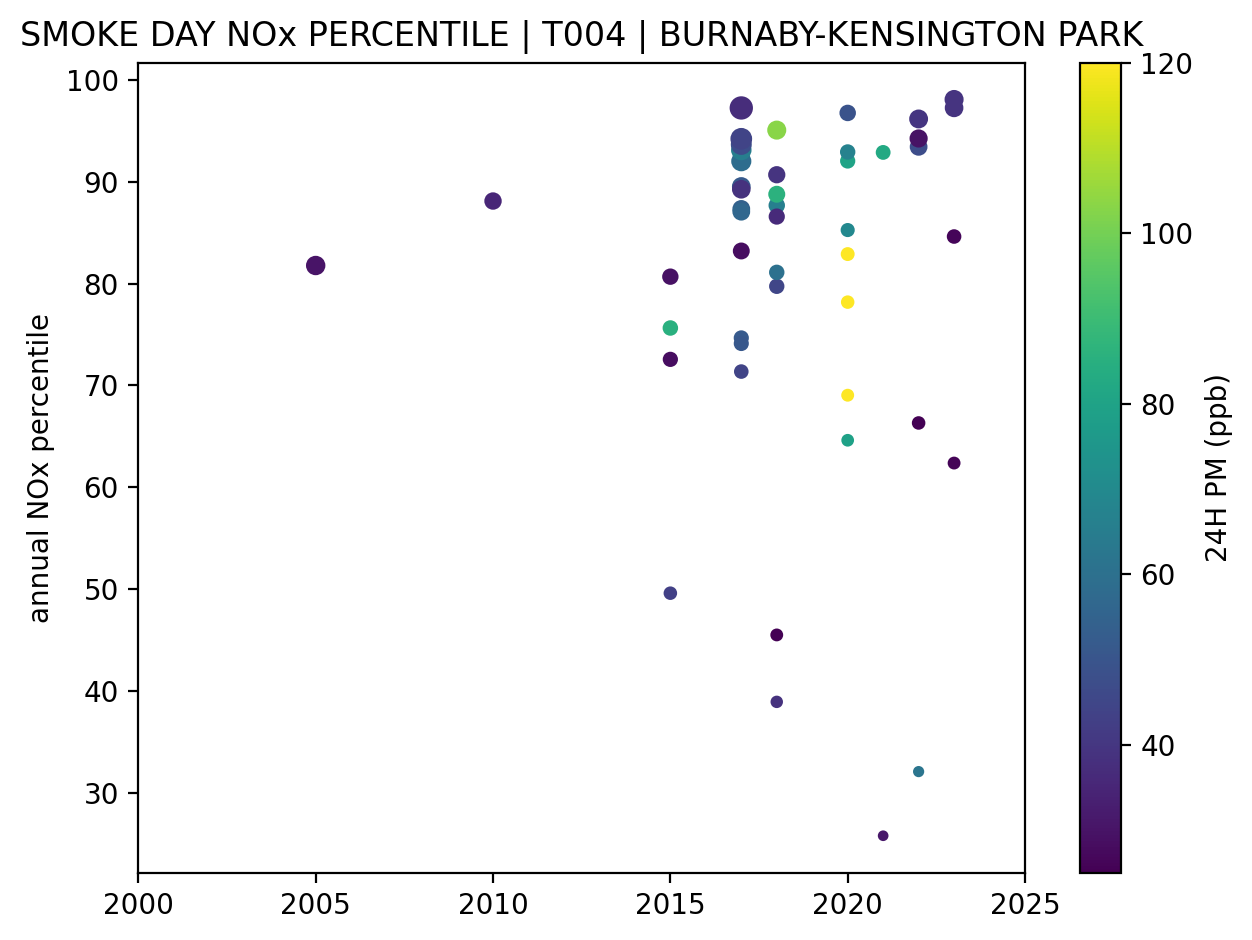

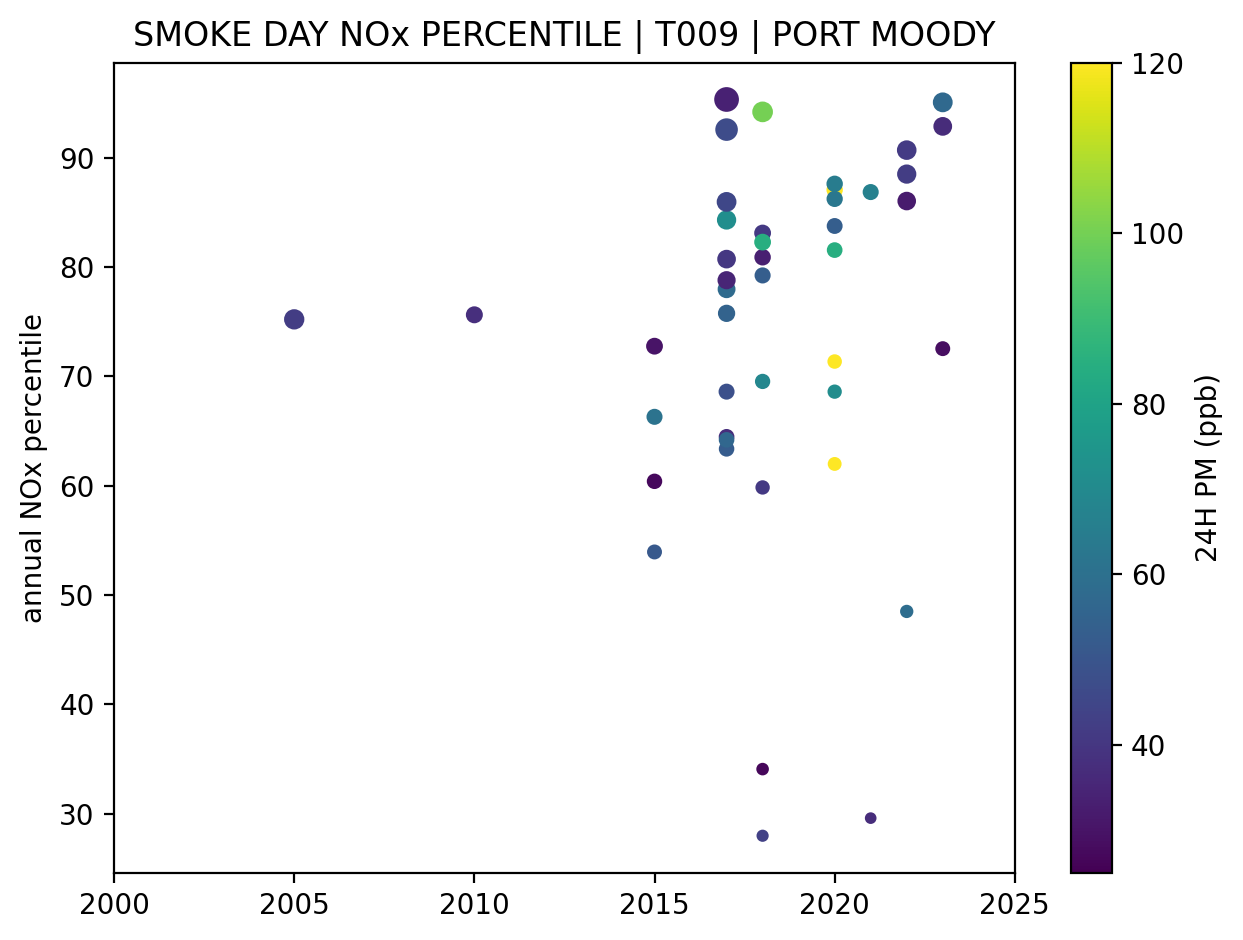

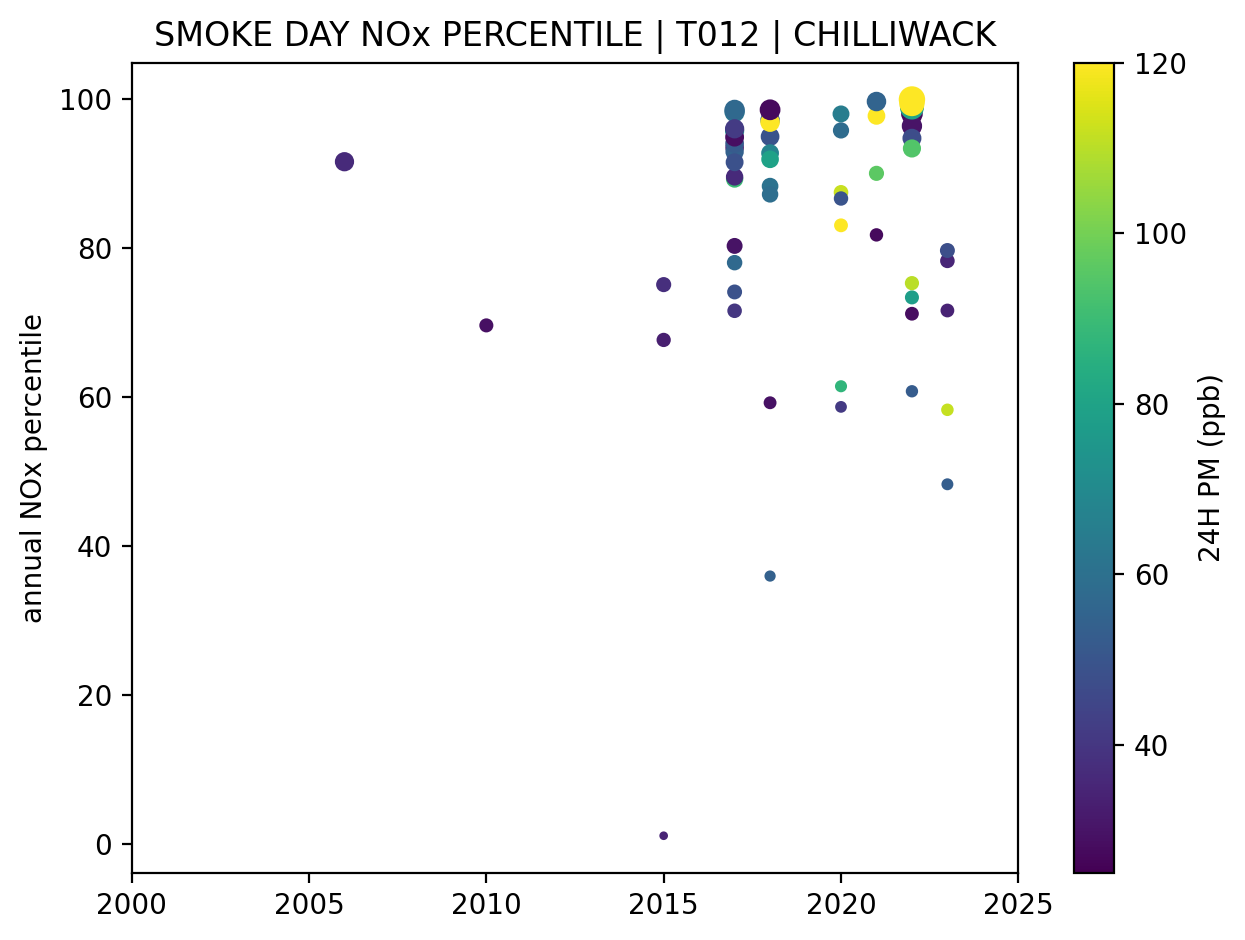

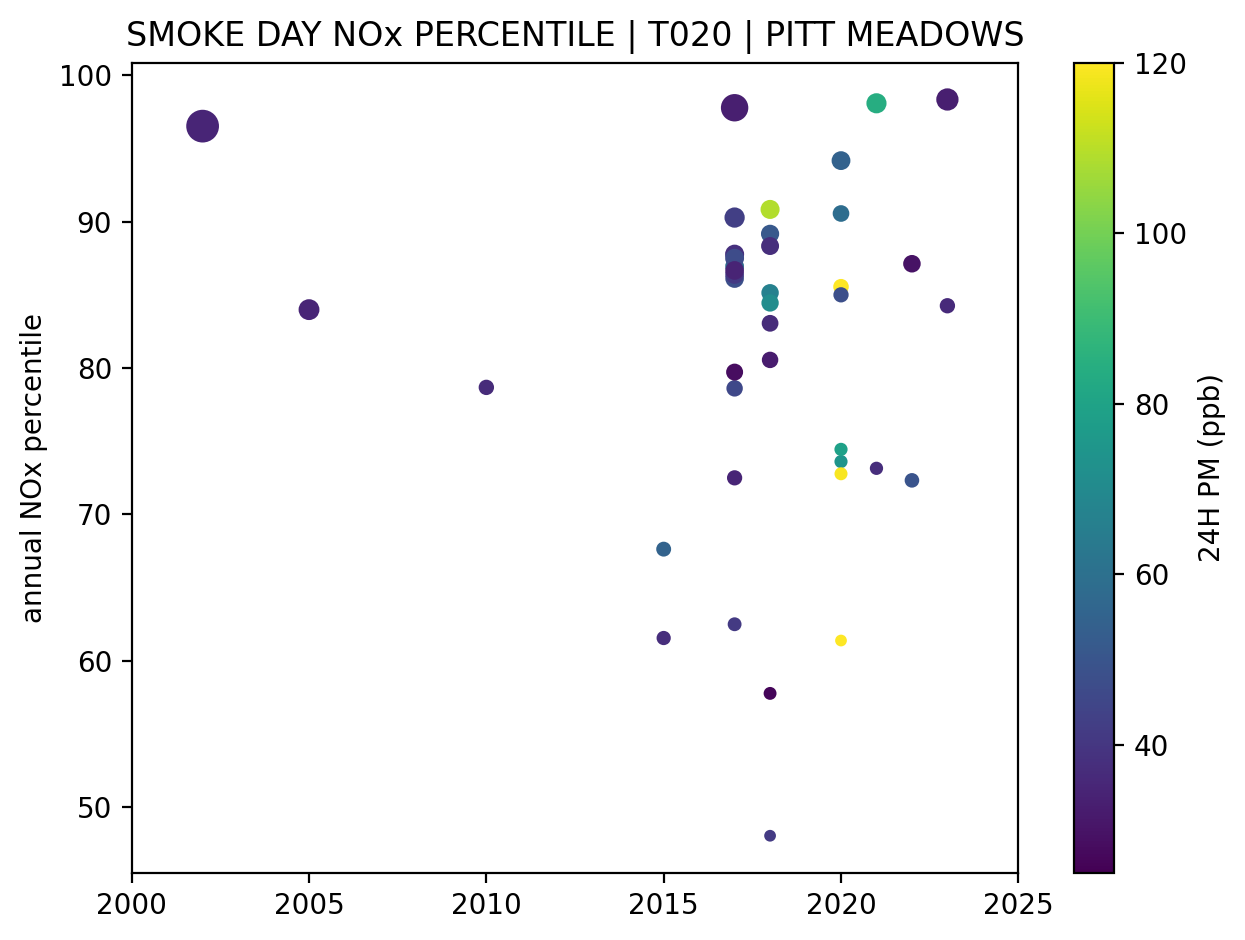

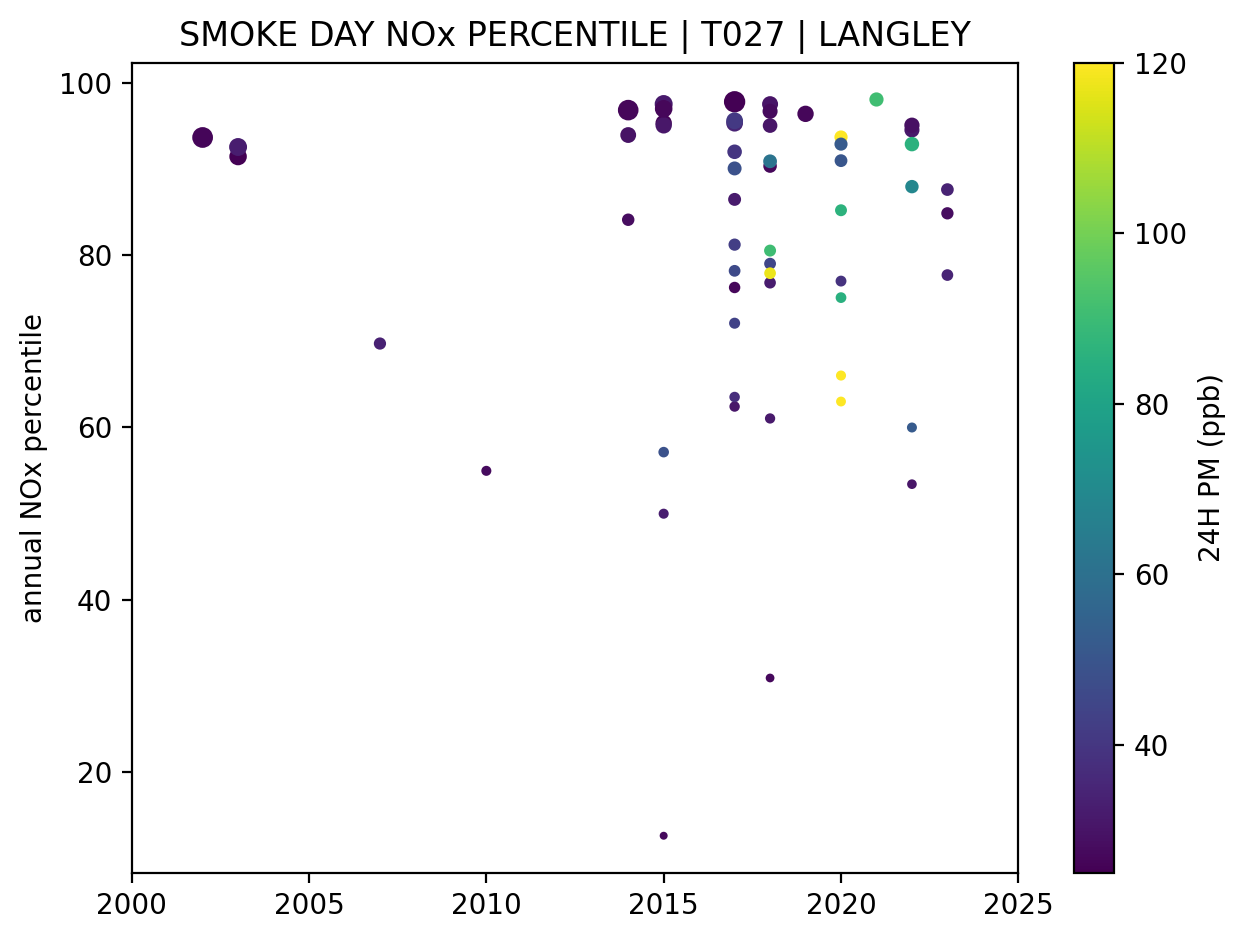

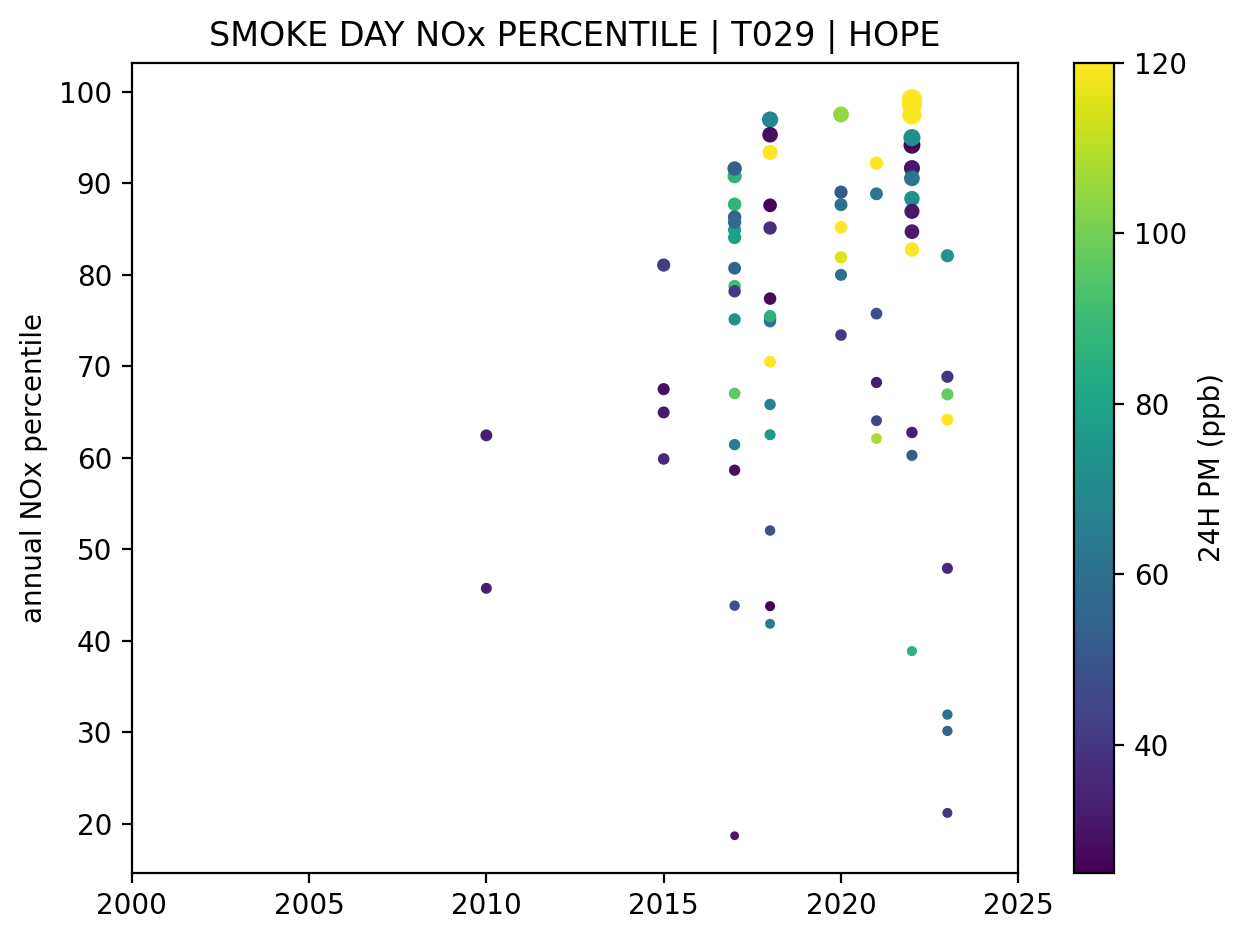

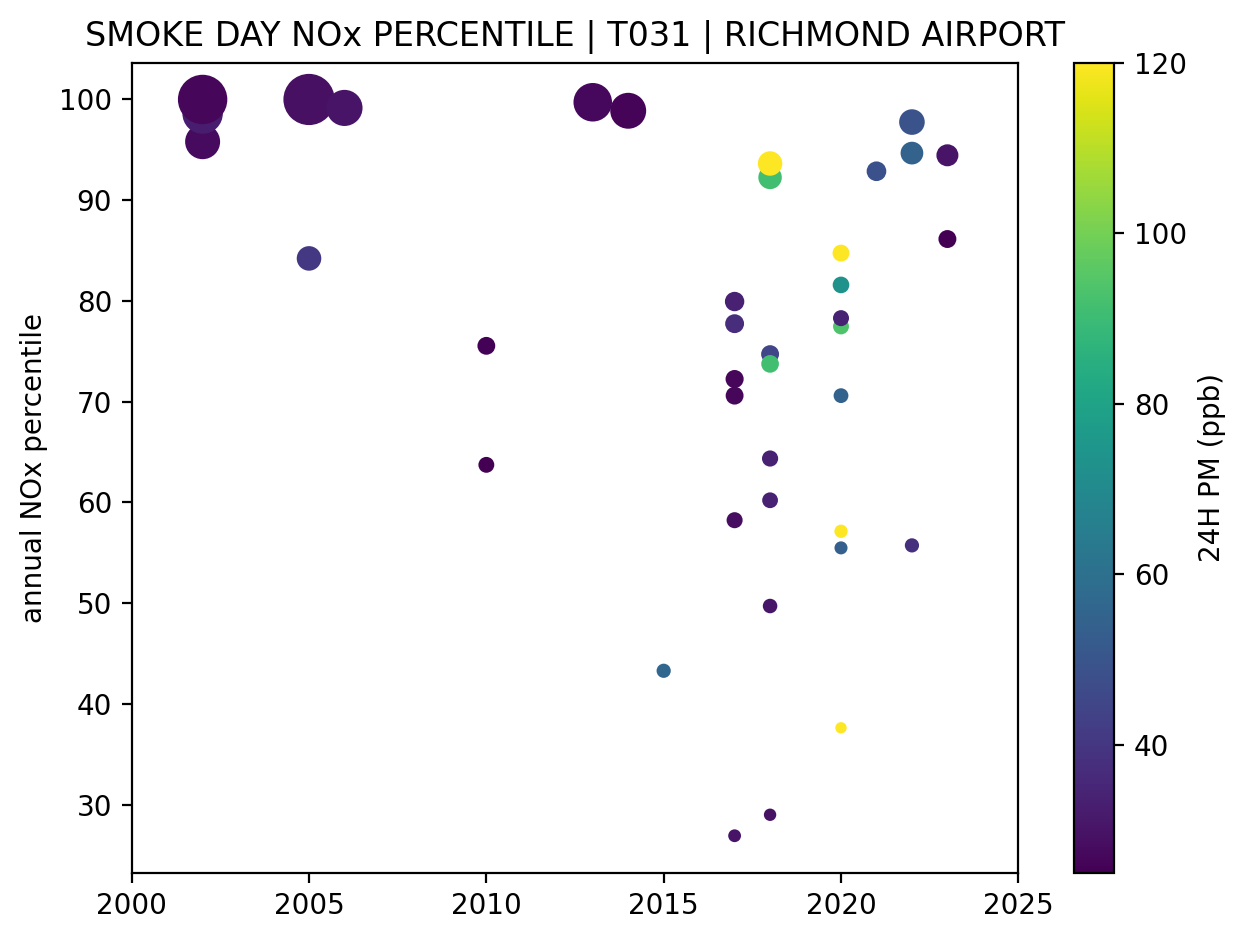

In [136]:
#-----SMOKE x NOx analysis------

store_pm_nox = pd.DataFrame(columns = ('station','date','year','pm','nox','nox_q'))


#load PM data
pm_24h = pd.read_pickle(pm_24h_path)

cnt = 0

for nStn, stn in enumerate(pm_stations):
  #apply ecxeedance criteria
  smoke_days = pm_24h[stn].loc[pm_24h[stn].ge(25)]


  for pm_date, pm_val in smoke_days.items():
    #get nox value on that day
    nox_val = nox_24h[stn].loc[pm_date]

    #get quantile of that value within that year
    current_yr_nox = nox_24h[stn][nox_24h.index.year == pm_date.year]
    qval = stats.percentileofscore(current_yr_nox[~np.isnan(current_yr_nox)],nox_val)
    store_pm_nox.loc[cnt,['station','date','year','pm','nox','nox_q']] = [stn, pm_date, pm_date.year, pm_val, nox_val, qval]

    cnt = cnt+1

  #do station scatterplot
  plt.figure()
  ax = plt.gca()
  plt.scatter(store_pm_nox[store_pm_nox.station==stn].year, store_pm_nox[store_pm_nox.station==stn].nox_q,\
              c=store_pm_nox[store_pm_nox.station==stn].pm, vmin=25, vmax=120, \
              s=pd.to_numeric(store_pm_nox[store_pm_nox.station==stn].nox))
  plt.colorbar(label='24H PM (ppb)')
  ax.set(title=f'SMOKE DAY NOx PERCENTILE | {stn} | {meta.loc[stn,"StationName"]}',xlim=[2000,2025], ylabel = 'annual NOx percentile')
  plt.tight_layout()







In [ ]:
# https://www2.gov.bc.ca/assets/gov/environment/air-land-water/air/reports-pub/air-zone-reports/2018-to-2020/lfv_air_zone_report_2018_to_2020.pdf